In [1]:
# Imports 

import torch 
import torch.utils.data
import torch.nn as nn 
from torch.nn import functional as F 
import torch.optim as optim 
import torchvision 
from torchvision import datasets, transforms 
import torchvision.models as models 
from torch.autograd import Variable 
from torch.utils.data import Dataset, DataLoader 

import time 
import random 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.transforms as matpl_tr 
from matplotlib.ticker import FormatStrFormatter
from PIL import Image 
import math 
import matplotlib 
import os 
from skimage.restoration import denoise_wavelet, estimate_sigma 
from skimage import data, img_as_float 
from skimage.util import random_noise 
from skimage.metrics import peak_signal_noise_ratio 
from sklearn.decomposition import PCA

# https://github.com/fbcotter/pytorch_wavelets
from pytorch_wavelets import DWTForward, DWTInverse

In [2]:
# Directory

!ls

#%cd '/home/ssadiku/**WaveletBasedLowFrequencyAdversarialAttacks**'

attacks.py	      Image_for_Fig_1.png    Models	 utils.py
CW_attack.png	      LF_CW_attack.png	     models.py
CW_perturbations.png  LFCW_perturbation.png  Saves
DWT_LF_Attacks.ipynb  main.py		     TEST.ipynb


In [3]:
class Attack(object):
    '''
    Root class for all adversarial attack classes.
    '''

    def __init__(self, model, targeted=False, img_range=(0, 1)):

        if img_range[0] >= img_range[1]:
            raise ValueError(
                ":img_range: Upper bound for pixel values must be greater than"
                " lower bound.")
        
        self.model = model
        self.device = next(model.parameters()).device
        self.targeted = targeted
        self.img_range = img_range

    def __repr__(self):
        return str(self.__dict__)

    def to(self, device):
        self.model.to(device)
        self.device = device



class FGM(Attack):
    '''
    :__call__: method performs FGM attack (FGSM if :norm: is set to 'inf').

    :model:       PyTorch model
    :norm:        string 'inf' for FGSM, anything else for L_2 FGM
    :targeted:    bool, targets will be used as true labels is set to False
    :img_range:   tuple, max and min pixel value
    :name:        optional string, name of the attack
    '''
    def __init__(self, model, norm='inf', targeted=False, img_range=(0, 1),
                 name=None):
        super().__init__(model, targeted=targeted, img_range=img_range)
        self.loss_fn = nn.CrossEntropyLoss()
        self.norm = norm
        if name is None:
            self.name = 'FGM'
        else:
            self.name = name


    def __call__(self, x, y, eps=0.0):
        
        x = x.to(self.device).detach()
        y = y.to(self.device).detach()
        x.requires_grad = True
        
        outs = self.model(x)
        self.model.zero_grad()
        loss = self.loss_fn(outs, y).to(self.device)
        loss.backward()

        if self.norm == 'inf':
            adv = x + (1 - 2 * self.targeted) * eps * x.grad.sign()
        else:
            tmp = x.grad.view(x.shape[0], -1).norm(self.norm, dim=-1)
            tmp = tmp.view(-1, 1, 1, 1)
            adv = x + (1 - 2 * self.targeted) * eps * x.grad / tmp

        return torch.clamp(adv, *self.img_range).detach()
        


class PGD(FGM):
    '''
    :__call__: method performs L_inf or L_2 PGD attack.

    :model:         PyTorch model
    :rand_restarts: int, number of random restarts
    :init_radius:   float, radius of the ball from which to draw restart points
    :iters:         int, number of PGD iterations
    :norm:          string 'inf' for FGSM, anything else for L_2 FGM
    :targeted:      bool, targets will be used as true labels is set to False
    :img_range:     tuple, max and min pixel value
    :name:          optional string, name of the attack
    '''
    def __init__(self, model, rand_restarts=0, init_radius=0, iters=10,
                 norm='inf', targeted=False, img_range=(0,1), name=None):
        super().__init__(model, norm=norm, targeted=targeted, img_range=img_range)
        self.init_radius = init_radius
        self.rand_restarts = rand_restarts
        self.iters = iters
        if name is None:
            self.name = 'PGD'
        else:
            self.name = name

    def __call__(self, x, y, eps=0.0):

        x = x.to(self.device)
        y = y.to(self.device)
        alpha = eps / self.iters
        loss_fn_no_reduction = nn.CrossEntropyLoss(reduction='none')
        targT = (torch.ones_like(y) * self.targeted).bool()
        b_size = x.shape[0]
        best_adv = x.clone()
        best_loss = [float('inf') if self.targeted else 0] * x.shape[0]

        for i in range(self.rand_restarts + 1):
            x_ = x + torch.zeros_like(x).uniform_(-self.init_radius, self.init_radius)

            for j in range(self.iters):
                x_ = super().__call__(x_, y, alpha)

                if self.norm == 'inf':
                    x_ = torch.max(torch.min(x_, x + eps), x - eps)
                else:
                    red_range = list(range(1, len(x.shape)))
                    pert = x_ - x
                    scale = torch.sum(pert ** 2, dim=red_range, keepdim=True)
                    scale[(scale.clone() == 0)] = 1e-9
                    factor = torch.min(torch.ones((1), device=self.device), eps / scale)
                    x_ = x + pert * factor

            logits = self.model(x_)
            predictions = torch.argmax(nn.Softmax(dim=1)(logits), dim=1)
            success = torch.logical_xor((predictions == y), targT)
            losses = loss_fn_no_reduction(logits, y)

            for k, (s, l) in enumerate(zip(success, losses)):
                tmp = (1 - 2 * self.targeted)
                if (s and tmp * l >= tmp * best_loss[k]) or i == 0:
                    best_adv[k] = x_[k].clone()
                    best_loss[k] = l

        return best_adv



class Auto_PGD(Attack):
    '''
    Auto-PGD L_inf attack https://arxiv.org/pdf/2003.01690.pdf
    Code adapted from https://github.com/fra31/auto-attack
    '''
    def __init__(self, model, n_restarts=1, n_iter=100, rho=0.75,
                 use_large_eps=False, eot_iter=1, topk=None, seed=None,
                 loss='dlr', targeted=False, img_range=(0,1), name=None):
        super().__init__(model, targeted=targeted, img_range=img_range)
        self.n_restarts = n_restarts
        self.n_iter = n_iter
        self.thr_decr = rho
        self.use_large_eps = use_large_eps
        self.eot_iter = eot_iter
        self.topk = topk
        self.loss = loss

        if seed is None:
            self.seed = time.time()
        else:
            self.seed = seed

        ### set parameters for checkpoints
        self.n_iter_2 = max(int(0.22 * self.n_iter), 1)
        self.n_iter_min = max(int(0.06 * self.n_iter), 1)
        self.size_decr = max(int(0.03 * self.n_iter), 1)

        if name is None:
            self.name = 'Auto_PGD'
        else:
            self.name = name


    def __call__(self, x, y, eps=0.03, best_loss=False, x_init=None):
        x = x.to(self.device)
        y = y.to(self.device)
        self.eps = eps
        self.init_hyperparam(x)

        x = x.detach().clone().float().to(self.device)
        y_pred = self.model(x).max(1)[1]
        adv = x.clone()
        acc = y_pred == y
        loss = -1e10 * torch.ones_like(acc).float()

        startt = time.time()
        if not best_loss:
            torch.random.manual_seed(self.seed)
            torch.cuda.random.manual_seed(self.seed)

            for counter in range(self.n_restarts):
                ind_to_fool = acc.nonzero().squeeze()
                if len(ind_to_fool.shape) == 0:
                    ind_to_fool = ind_to_fool.unsqueeze(0)
                if ind_to_fool.numel() != 0:
                    x_to_fool = x[ind_to_fool].clone()
                    y_to_fool = y[ind_to_fool].clone()
                    res_curr = self.attack_single_run(x_to_fool, y_to_fool)
                    best_curr, acc_curr, loss_curr, adv_curr = res_curr
                    ind_curr = (acc_curr == 0).nonzero().squeeze()

                    acc[ind_to_fool[ind_curr]] = 0
                    adv[ind_to_fool[ind_curr]] = adv_curr[ind_curr].clone()

            return adv

        else:
            adv_best = x.detach().clone()
            loss_best = torch.ones([x.shape[0]]).to(self.device)*(-float('inf'))
            for counter in range(self.n_restarts):
                best_curr, _, loss_curr, _ = self.attack_single_run(x, y)
                ind_curr = (loss_curr > loss_best).nonzero().squeeze()
                adv_best[ind_curr] = best_curr[ind_curr] + 0.
                loss_best[ind_curr] = loss_curr[ind_curr] + 0.

            return adv_best.detach()


    def attack_single_run(self, x, y, x_init=None):
        t = 2 * torch.rand(x.shape).to(self.device).detach() - 1
        x_adv = x + self.eps * torch.ones_like(x).detach() * self.normalize(t)

        if not x_init is None:
            x_adv = x_init.clone()

        x_adv = x_adv.clamp(0., 1.)
        x_best = x_adv.clone()
        x_best_adv = x_adv.clone()
        loss_steps = torch.zeros([self.n_iter, x.shape[0]]).to(self.device)
        loss_best_steps = torch.zeros([self.n_iter + 1, x.shape[0]]
                                      ).to(self.device)
        acc_steps = torch.zeros_like(loss_best_steps)

        if self.loss == 'ce':
            criterion_indiv = nn.CrossEntropyLoss(reduction='none')
        elif self.loss == 'dlr':
            criterion_indiv = self.dlr_loss
        else:
            raise ValueError('unknowkn loss')

        x_adv.requires_grad_()
        grad = torch.zeros_like(x)
        for _ in range(self.eot_iter):
            with torch.enable_grad():
                logits = self.model(x_adv)
                loss_indiv = criterion_indiv(logits, y)
                loss = loss_indiv.sum()

            grad += torch.autograd.grad(loss, [x_adv])[0].detach()

        grad /= float(self.eot_iter)
        grad_best = grad.clone()

        acc = logits.detach().max(1)[1] == y
        acc_steps[0] = acc + 0
        loss_best = loss_indiv.detach().clone()

        alpha = 2.
        step_size = alpha * self.eps * torch.ones([x.shape[0], *(
            [1] * self.ndims)]).to(self.device).detach()
        x_adv_old = x_adv.clone()
        counter = 0
        k = self.n_iter_2 + 0
        n_fts = math.prod(self.orig_dim)
        counter3 = 0

        loss_best_last_check = loss_best.clone()
        reduced_last_check = torch.ones_like(loss_best)
        n_reduced = 0

        u = torch.arange(x.shape[0], device=self.device)
        for i in range(self.n_iter):
            ### gradient step
            with torch.no_grad():
                x_adv = x_adv.detach()
                grad2 = x_adv - x_adv_old
                x_adv_old = x_adv.clone()

                a = 0.75 if i > 0 else 1.0

                x_adv_1 = x_adv + step_size * torch.sign(grad)
                x_adv_1 = torch.clamp(torch.min(torch.max(x_adv_1,
                    x - self.eps), x + self.eps), 0.0, 1.0)
                x_adv_1 = torch.clamp(torch.min(torch.max(
                    x_adv + (x_adv_1 - x_adv) * a + grad2 * (1 - a),
                    x - self.eps), x + self.eps), 0.0, 1.0)
                    
                x_adv = x_adv_1 + 0.

            ### get gradient
            x_adv.requires_grad_()
            grad = torch.zeros_like(x)
            for _ in range(self.eot_iter):
                with torch.enable_grad():
                    logits = self.model(x_adv)
                    loss_indiv = criterion_indiv(logits, y)
                    loss = loss_indiv.sum()
    
                grad += torch.autograd.grad(loss, [x_adv])[0].detach()
            grad /= float(self.eot_iter)

            pred = logits.detach().max(1)[1] == y
            acc = torch.min(acc, pred)
            acc_steps[i + 1] = acc + 0
            ind_pred = (pred == 0).nonzero().squeeze()
            x_best_adv[ind_pred] = x_adv[ind_pred].detach() + 0.
            
            ### check step size
            with torch.no_grad():
                y1 = loss_indiv.detach().clone()
                loss_steps[i] = y1 + 0
                ind = (y1 > loss_best).nonzero().squeeze()
                x_best[ind] = x_adv[ind].detach().clone()
                grad_best[ind] = grad[ind].clone()
                loss_best[ind] = y1[ind] + 0
                loss_best_steps[i + 1] = loss_best + 0

                counter3 += 1

                if counter3 == k:
                    
                    fl_oscillation = self.check_oscillation(loss_steps, i, k,
                        loss_best, k3=self.thr_decr)
                    fl_reduce_no_impr = (1. - reduced_last_check) * (
                        loss_best_last_check >= loss_best).float()
                    fl_oscillation = torch.max(fl_oscillation,
                        fl_reduce_no_impr)
                    reduced_last_check = fl_oscillation.clone()
                    loss_best_last_check = loss_best.clone()

                    if fl_oscillation.sum() > 0:
                        ind_fl_osc = (fl_oscillation > 0).nonzero().squeeze()
                        step_size[ind_fl_osc] /= 2.0
                        n_reduced = fl_oscillation.sum()

                        x_adv[ind_fl_osc] = x_best[ind_fl_osc].clone()
                        grad[ind_fl_osc] = grad_best[ind_fl_osc].clone()

                    k = max(k - self.size_decr, self.n_iter_min)
                    counter3 = 0

        return (x_best.detach(), acc, loss_best, x_best_adv.detach())


    def dlr_loss(self, x, y):
        x_sorted, ind_sorted = x.sort(dim=1)
        ind = (ind_sorted[:, -1] == y).float()
        u = torch.arange(x.shape[0])
        return -(x[u, y] - x_sorted[:, -2] * ind - x_sorted[:, -1] * (
            1. - ind)) / (x_sorted[:, -1] - x_sorted[:, -3] + 1e-12)


    def normalize(self, x):
        t = x.abs().view(x.shape[0], -1).max(1)[0]
        return x / (t.view(-1, *([1] * self.ndims)) + 1e-12)

    
    def init_hyperparam(self, x):
        self.orig_dim = list(x.shape[1:])
        self.ndims = len(self.orig_dim)

    
    def check_oscillation(self, x, j, k, y5, k3=0.75):
        t = torch.zeros(x.shape[1]).to(self.device)
        for counter5 in range(k):
            t += (x[j - counter5] > x[j - counter5 - 1]).float()
        return (t <= k * k3 * torch.ones_like(t)).float()



class CWL2(Attack):
    '''
    :__call__: method performs Carlini-Wagner L_2 attack.

    :model:         PyTorch model
    :targeted:      bool, targets will be used as true labels is set to False
    :img_range:     tuple, max and min pixel value
    :kappa:         float, confidence parameter
    :max_iter:      number of gradient descent steps
    :ver:           bool, print progress of set to True
    :lr:            float, learning rate for Adam optimizer
    :search_steps:  int, number of binary search steps for tradeoff parameter c
    :max_c:         float, upper bound for c
    :name:          optional string, name of the attack
    '''
    def __init__(self, model, targeted=False, img_range=(0, 1), kappa=0, 
                 max_iter=1000, ver=False, lr=0.01, search_steps=1, max_c=1e10,
                 name=None):
        super().__init__(model, targeted=targeted, img_range=img_range)
        self.loss_fn = nn.CrossEntropyLoss()
        self.kappa = kappa
        self.max_iter = max_iter
        self.ver = ver
        self.lr = lr
        self.search_steps = search_steps
        self.max_c = max_c
        if name is None:
            self.name = 'CWL2'
        else:
            self.name = name

    def compare(self, x, y):
        return torch.equal(x, y) if self.targeted else not torch.equal(x, y)

    def f(self, x, y):
        #f from page 9 of the C&W paper
        logits = self.model(x)
        one_hot_labels = F.one_hot(y, logits.size(1)).to(self.device)
        Z_i = torch.max(logits * (1 - one_hot_labels) - one_hot_labels * 10000., dim = 1)[0]
        Z_t = torch.sum(logits * one_hot_labels, dim=1)
        Zdif = Z_i - Z_t if self.targeted else Z_t - Z_i
        return torch.clamp(Zdif + self.kappa, min=0.0)
    
    def __call__(self, x_, y, c):

        batch_size = x_.shape[0]
        x_ = x_.to(self.device)
        y = y.to(self.device)

        lower_bound = torch.zeros(batch_size)
        cs = torch.ones(batch_size, device=self.device) * c
        upper_bound = torch.ones(batch_size) * self.max_c

        bestl2 = [1e+10 for i in range(batch_size)]
        best_attack = x_.clone().detach().to(self.device)
        success = [0 for i in range(batch_size)]

        for step in range(self.search_steps):

            #optimize w obtained by change of variables
            w = torch.zeros_like(x_, requires_grad=True).to(self.device)
            optimizer = optim.Adam([w], lr=self.lr)

            for iter_ in range(self.max_iter):
                #attack step
                x = .5*(torch.tanh(w) + 1)

                optimizer.zero_grad()
                cost1 = F.mse_loss(x, x_)
                cost2 = cs * self.f(x, y)
                cost = torch.sum(cost1 + cost2)
                cost.backward()
                optimizer.step()

                if (not iter_%100 or iter_ == self.max_iter - 1) and self.ver:
                    print(f'\rIteration: {iter_+1}/{self.max_iter}, Search Step: {step+1}/{self.search_steps}', end='')

            x = .5*(torch.tanh(w) + 1)
            preds = torch.argmax(nn.Softmax(dim=1)(self.model(x)), dim=1)
            perturbations = x - x_

            # check if attack is better than current best
            for i, pert in enumerate(perturbations):
                l2 = torch.norm(pert, p=2)
                if l2 < bestl2[i] and self.compare(preds[i], y[i]):
                    bestl2[i] = l2
                    best_attack[i] = x[i].detach()
                    success[i] = 1
                else:
                    success[i] = 0

            # binary search step
            for i, s in enumerate(success):
                if s == 1:
                    upper_bound[i] = min(upper_bound[i], cs[i])
                    if upper_bound[i] < 1e9:
                        cs[i] = (lower_bound[i] + upper_bound[i]) / 2
                else:
                    lower_bound[i] = max(lower_bound[i], cs[i])
                    if upper_bound[i] < 1e9:
                        cs[i] = (lower_bound[i] + upper_bound[i]) / 2
                    else:
                        cs[i] *= 10

            if self.search_steps == 1:
                best_attack = x.clone().detach()

        if self.ver:
            print('')
        return best_attack

    
class DWT_FGSM(Attack):
    '''
    :__call__: method performs low-frequency DWT FGSM attack.

    :model:       PyTorch model
    :norm:        string 'inf' for FGSM, anything else for L_2 FGM
    :targeted:    bool, targets will be used as true labels is set to False
    :img_range:   tuple, max and min pixel value
    :J:           int, DWT decomposition scale
    :mode:        str, padding mode for :pytorch_wavelets: DWT classes
    :wave:        str, wavelet used for DWT
    :name:        optional string, name of the attack
    '''
    def __init__(self, model, targeted=False, img_range=(0, 1),
                 J=1, mode='periodization', wave='db3', name=None):
        super().__init__(model, targeted=targeted, img_range=img_range)
        self.loss_fn = nn.CrossEntropyLoss()
        self.DWT = DWTForward(J=J, wave=wave, mode=mode).to(self.device)
        self.iDWT = DWTInverse(wave=wave, mode=mode).to(self.device)
        if name is None:
            self.name = 'DWT_FGSM'
        else:
            self.name = name

    def to(self, device):
        super().to(device)
        self.DWT.to(device)
        self.iDWT.to(device)

    def __call__(self, x, y, eps=0.0):
        x_l, x_h = self.FGSM_no_iDWT(x, y, eps)
        return torch.clamp(self.iDWT((x_l, x_h)), *self.img_range).detach()

    def FGSM_no_iDWT(self, x, y, eps=0.0):
        x = x.to(self.device)
        y = y.to(self.device)
        
        x_l, x_h = self.DWT(x)
        x_l.requires_grad = True
        
        outs = self.model(self.iDWT((x_l, x_h)))
        self.model.zero_grad()
        loss = self.loss_fn(outs, y).to(self.device)
        loss.backward()
        
        tmp = (1 - 2 * self.targeted)
        x_l = (x_l + tmp * eps * x_l.grad.sign()).detach()
        
        return x_l, x_h


class All_Freq_FGSM(DWT_FGSM):
    '''
    Adaptation of low frequency FGSM attack class.
    __call__ method performs FGSM attack in the Dwt domain (on all coefficients)
    '''
    def FGSM_no_iDWT(self, x, y, eps=0.0):
        x = x.to(self.device)
        y = y.to(self.device)
        
        x_l, x_h = self.DWT(x)
        x_l.requires_grad = True
        x_h = [h.requires_grad_(True) for h in x_h]
        
        outs = self.model(self.iDWT((x_l, x_h)))
        self.model.zero_grad()
        loss = self.loss_fn(outs, y).to(self.device)
        loss.backward()
        
        tmp = (1 - 2 * self.targeted)
        x_l = (x_l + tmp * eps * x_l.grad.sign()).detach()
        x_h = [(h + tmp * eps * h.grad.sign()).detach() for h in x_h]
        
        return x_l, x_h


class DWT_PGD(DWT_FGSM):
    '''
    :__call__: method performs low frequency DWT L_inf PGD attack.

    :model:         PyTorch model
    :rand_restarts: int, number of random restarts
    :init_radius:   float, radius of the ball from which to draw restart points
    :iters:         int, number of PGD iterations
    :norm:          string 'inf' for FGSM, anything else for L_2 FGM
    :targeted:      bool, targets will be used as true labels is set to False
    :img_range:     tuple, max and min pixel value
    :J:           int, DWT decomposition scale
    :mode:        str, padding mode for :pytorch_wavelets: DWT classes
    :wave:        str, wavelet used for DWT
    :name:          optional string, name of the attack
    '''
    def __init__(self, model, rand_restarts=0, init_radius=0, iters=10,
                 targeted=False, img_range=(0,1), J=1, mode='periodization',
                 wave='db3', name=None):
        super().__init__(model, targeted=targeted, img_range=img_range, J=J,
                         mode=mode, wave=wave)
        self.init_radius = init_radius
        self.rand_restarts = rand_restarts
        self.iters = iters
        if name is None:
            self.name = 'DWT_PGD'
        else:
            self.name = name

    def __call__(self, x, y, eps=0.0):
        x = x.to(self.device)
        y = y.to(self.device)
        alpha = eps / self.iters
        loss_fn_no_reduction = nn.CrossEntropyLoss(reduction='none')
        targT = (torch.ones_like(y) * self.targeted).bool()
        b_size = x.shape[0]
        best_adv = x.clone()
        best_loss = [float('inf') if self.targeted else 0] * x.shape[0]
        x_l_, x_h_ = self.DWT(x)

        for i in range(self.rand_restarts + 1):
            x_ = x + torch.zeros_like(x).uniform_(-self.init_radius, self.init_radius)

            for j in range(self.iters):
                x_l, x_h = self.FGSM_no_iDWT(x_, y, alpha)
                x_l = torch.max(torch.min(x_l, x_l_ + eps), x_l_ - eps)
                x_ = self.iDWT((x_l, x_h)).detach()

            x_ = x_.clamp(*self.img_range).detach()
            logits = self.model(x_)
            predictions = torch.argmax(nn.Softmax(dim=1)(logits), dim=1)
            success = torch.logical_xor((predictions == y), targT)
            losses = loss_fn_no_reduction(logits, y)

            for k, (s, l) in enumerate(zip(success, losses)):
                tmp = (1 - 2 * self.targeted)
                if (s and tmp * l >= tmp * best_loss[k]) or i == 0:
                    best_adv[k] = x_[k].clone()
                    best_loss[k] = l

        return best_adv



class DWT_Auto_PGD(Attack):
    '''
    DWT Auto-PGD L_inf
    Code adapted from https://github.com/fra31/auto-attack
    '''
    def __init__(self, model, n_restarts=1, n_iter=100, rho=0.75,
                 use_large_eps=False, eot_iter=1, topk=None, seed=None,
                 loss='dlr', J=1, mode='periodization', wave='db3',
                 targeted=False, img_range=(0,1), name=None):
        super().__init__(model, targeted=targeted, img_range=img_range)
        self.n_restarts = n_restarts
        self.n_iter = n_iter
        self.thr_decr = rho
        self.use_large_eps = use_large_eps
        self.eot_iter = eot_iter
        self.topk = topk
        self.loss = loss
        self.J = J
        self.DWT = DWTForward(J=J, wave=wave, mode=mode).to(self.device)
        self.iDWT = DWTInverse(wave=wave, mode=mode).to(self.device)

        if seed is None:
            self.seed = time.time()
        else:
            self.seed = seed

        ### set parameters for checkpoints
        self.n_iter_2 = max(int(0.22 * self.n_iter), 1)
        self.n_iter_min = max(int(0.06 * self.n_iter), 1)
        self.size_decr = max(int(0.03 * self.n_iter), 1)

        if name is None:
            self.name = 'DWT_Auto_PGD'
        else:
            self.name = name


    def __call__(self, x, y, eps, best_loss=False, x_init=None):
        x = x.to(self.device)
        y = y.to(self.device)
        self.eps = eps
        x_l, x_h = self.DWT(x)
        self.init_hyperparam(x_l)

        x = x.detach().clone().float().to(self.device)
        y_pred = self.model(x).max(1)[1]
        adv = x.clone()
        acc = y_pred == y
        loss = -1e10 * torch.ones_like(acc).float()

        startt = time.time()
        if not best_loss:
            torch.random.manual_seed(self.seed)
            torch.cuda.random.manual_seed(self.seed)

            for counter in range(self.n_restarts):
                ind_to_fool = acc.nonzero().squeeze()
                if len(ind_to_fool.shape) == 0:
                    ind_to_fool = ind_to_fool.unsqueeze(0)
                if ind_to_fool.numel() != 0:
                    x_to_fool = x[ind_to_fool].clone()
                    y_to_fool = y[ind_to_fool].clone()
                    res_curr = self.attack_single_run(x_to_fool, y_to_fool)
                    best_curr, acc_curr, loss_curr, adv_curr = res_curr
                    ind_curr = (acc_curr == 0).nonzero().squeeze()

                    acc[ind_to_fool[ind_curr]] = 0
                    adv[ind_to_fool[ind_curr]] = adv_curr[ind_curr].clone()

            return adv

        else:
            adv_best = x.detach().clone()
            loss_best = torch.ones([x.shape[0]]).to(self.device)*(-float('inf'))
            for counter in range(self.n_restarts):
                best_curr, _, loss_curr, _ = self.attack_single_run(x, y)
                ind_curr = (loss_curr > loss_best).nonzero().squeeze()
                adv_best[ind_curr] = best_curr[ind_curr] + 0.
                loss_best[ind_curr] = loss_curr[ind_curr] + 0.

            return adv_best.detach()


    def attack_single_run(self, x, y, x_init=None):
        x_l, x_h = self.DWT(x)
        t = 2 * torch.rand(x_l.shape).to(self.device).detach() - 1
        x_adv_l = x_l + self.eps * torch.ones_like(x_l).detach() * self.normalize(t)
        x_adv = self.iDWT((x_adv_l, x_h))

        if not x_init is None:
            x_adv = x_init.clone()

        x_adv = x_adv.clamp(0., 1.)
        x_best = x_adv.clone()
        x_best_adv = x_adv.clone()
        loss_steps = torch.zeros([self.n_iter, x.shape[0]]).to(self.device)
        loss_best_steps = torch.zeros([self.n_iter + 1, x.shape[0]]
                                      ).to(self.device)
        acc_steps = torch.zeros_like(loss_best_steps)

        if self.loss == 'ce':
            criterion_indiv = nn.CrossEntropyLoss(reduction='none')
        elif self.loss == 'dlr':
            criterion_indiv = self.dlr_loss
        else:
            raise ValueError('unknowkn loss')

        x_adv_l, x_adv_h = self.DWT(x_adv)
        grad = torch.zeros_like(x_l)
        x_adv_l.requires_grad = True
        for _ in range(self.eot_iter):
            with torch.enable_grad():
                logits = self.model(torch.clamp(self.iDWT((x_adv_l, x_adv_h)), 0, 1))
                loss_indiv = criterion_indiv(logits, y)
                loss = loss_indiv.sum()

            grad += torch.autograd.grad(loss, [x_adv_l])[0].detach()

        grad /= float(self.eot_iter)
        grad_best = grad.clone()

        acc = logits.detach().max(1)[1] == y
        acc_steps[0] = acc + 0
        loss_best = loss_indiv.detach().clone()

        alpha = 2.
        step_size = alpha * self.eps * torch.ones([x_adv_l.shape[0], *(
            [1] * self.ndims)]).to(self.device).detach()
        x_adv_l_old = x_adv_l.clone()
        counter = 0
        k = self.n_iter_2 + 0
        n_fts = math.prod(self.orig_dim)
        counter3 = 0

        loss_best_last_check = loss_best.clone()
        reduced_last_check = torch.ones_like(loss_best)
        n_reduced = 0

        u = torch.arange(x_adv_l.shape[0], device=self.device)
        for i in range(self.n_iter):
            ### gradient step
            with torch.no_grad():
                x_adv_l = x_adv_l.detach()
                grad2 = x_adv_l - x_adv_l_old
                x_adv_l_old = x_adv_l.clone()

                a = 0.75 if i > 0 else 1.0

                x_adv_1 = x_adv_l + step_size * torch.sign(grad)
                x_adv_1 = torch.min(torch.max(x_adv_1,
                    x_l - self.eps), x_l + self.eps)
                x_adv_1 = torch.min(torch.max(
                    x_adv_l + (x_adv_1 - x_adv_l) * a + grad2 * (1 - a),
                    x_l - self.eps), x_l + self.eps)
                    
                x_adv_l = x_adv_1 + 0.

            ### get gradient
            x_adv_l.requires_grad_()
            grad = torch.zeros_like(x_l)
            for _ in range(self.eot_iter):
                with torch.enable_grad():
                    logits = self.model(torch.clamp(self.iDWT((x_adv_l, x_adv_h)), 0, 1))
                    loss_indiv = criterion_indiv(logits, y)
                    loss = loss_indiv.sum()
    
                grad += torch.autograd.grad(loss, [x_adv_l])[0].detach()
            grad /= float(self.eot_iter)

            pred = logits.detach().max(1)[1] == y
            acc = torch.min(acc, pred)
            acc_steps[i + 1] = acc + 0
            ind_pred = (pred == 0).nonzero().squeeze()
            x_adv = torch.clamp(self.iDWT((x_adv_l.detach(), x_adv_h)), 0, 1)
            x_best_adv[ind_pred] = x_adv[ind_pred].detach() + 0.
            
            ### check step size
            with torch.no_grad():
                y1 = loss_indiv.detach().clone()
                loss_steps[i] = y1 + 0
                ind = (y1 > loss_best).nonzero().squeeze()
                x_best[ind] = x_adv[ind].detach().clone()
                grad_best[ind] = grad[ind].clone()
                loss_best[ind] = y1[ind] + 0
                loss_best_steps[i + 1] = loss_best + 0

                counter3 += 1

                if counter3 == k:
                    
                    fl_oscillation = self.check_oscillation(loss_steps, i, k,
                        loss_best, k3=self.thr_decr)
                    fl_reduce_no_impr = (1. - reduced_last_check) * (
                        loss_best_last_check >= loss_best).float()
                    fl_oscillation = torch.max(fl_oscillation,
                        fl_reduce_no_impr)
                    reduced_last_check = fl_oscillation.clone()
                    loss_best_last_check = loss_best.clone()

                    if fl_oscillation.sum() > 0:
                        ind_fl_osc = (fl_oscillation > 0).nonzero().squeeze()
                        step_size[ind_fl_osc] /= 2.0
                        n_reduced = fl_oscillation.sum()

                        x_adv[ind_fl_osc] = x_best[ind_fl_osc].clone()
                        grad[ind_fl_osc] = grad_best[ind_fl_osc].clone()

                    k = max(k - self.size_decr, self.n_iter_min)
                    counter3 = 0

        return (x_best.detach(), acc, loss_best, x_best_adv.detach())
        

    

    def dlr_loss(self, x, y):
        x_sorted, ind_sorted = x.sort(dim=1)
        ind = (ind_sorted[:, -1] == y).float()
        u = torch.arange(x.shape[0])
        return -(x[u, y] - x_sorted[:, -2] * ind - x_sorted[:, -1] * (
            1. - ind)) / (x_sorted[:, -1] - x_sorted[:, -3] + 1e-12)


    def normalize(self, x):
        t = x.abs().view(x.shape[0], -1).max(1)[0]
        return x / (t.view(-1, *([1] * self.ndims)) + 1e-12)

    
    def init_hyperparam(self, x):
        self.orig_dim = list(x.shape[1:])
        self.ndims = len(self.orig_dim)

    
    def check_oscillation(self, x, j, k, y5, k3=0.75):
        t = torch.zeros(x.shape[1]).to(self.device)
        for counter5 in range(k):
            t += (x[j - counter5] > x[j - counter5 - 1]).float()
        return (t <= k * k3 * torch.ones_like(t)).float()



class DWT_CWL2(Attack):
    '''
    :__call__: method performs low frequency DWT Carlini-Wagner L_2 attack.

    :model:         PyTorch model
    :targeted:      bool, targets will be used as true labels is set to False
    :img_range:     tuple, max and min pixel value
    :kappa:         float, confidence parameter
    :max_iter:      number of gradient descent steps
    :ver:           bool, print progress of set to True
    :lr:            float, learning rate for Adam optimizer
    :search_steps:  int, number of binary search steps for tradeoff parameter c
    :max_c:         float, upper bound for c
    :J:           int, DWT decomposition scale
    :mode:        str, padding mode for :pytorch_wavelets: DWT classes
    :wave:        str, wavelet used for DWT
    :name:          optional string, name of the attack
    '''
    def __init__(self, model, targeted=False, img_range=(0, 1), kappa=0, 
                 max_iter=1000, ver=False, lr=0.01, search_steps=1, max_c=1e10,
                 J=1, mode='periodization', wave='db4', name=None):
        super().__init__(model, targeted=targeted, img_range=img_range)
        self.loss_fn = nn.CrossEntropyLoss()
        self.kappa = kappa
        self.max_iter = max_iter
        self.ver = ver
        self.lr = lr
        self.search_steps = search_steps
        self.max_c = max_c
        self.J = J
        self.mode = mode
        self.wave = wave
        self.DWT = DWTForward(J=J, wave=wave, mode=mode).to(self.device)
        self.iDWT = DWTInverse(wave=wave, mode=mode).to(self.device)
        if name is None:
            self.name = 'DWT_CWL2'
        else:
            self.name = name

    def compare(self, x, y):
        return torch.equal(x, y) if self.targeted else not torch.equal(x, y)

    def f(self, x, y):
        #f from page 9 of the C&W paper
        logits = self.model(x)
        one_hot_labels = F.one_hot(y, logits.lize(1).item()).to(self.device)
        Z_i = torch.max(logits * (1 - one_hot_labels) - one_hot_labels * 10000., dim = 1)[0]
        Z_t = torch.sum(logits * one_hot_labels, dim=1)
        Zdif = Z_i - Z_t if self.targeted else Z_t - Z_i
        return torch.clamp(Zdif + self.kappa, min=0.0)

    def __call__(self, x_, y, c=0.00001):

        batch_size = x_.shape[0]
        
        batch_ = x_.to(self.device)
        labels = y.to(self.device)
        dwt_l, dwt_h = self.DWT(batch_)
        x_hat_l, x_hat_h = self.DWT(torch.atanh(torch.clip(2 * batch_ - 1, -.99, .99)))

        lower_bound = torch.zeros(batch_size)
        cs = torch.ones(batch_size, device=self.device) * c
        upper_bound = torch.ones(batch_size) * self.max_c

        bestl2 = [1e+10 for i in range(batch_size)]
        best_attack = batch_.clone().to(self.device)
        success = [0 for i in range(batch_size)]

        def compare(x, y):
            return torch.equal(x, y) if self.targeted else not torch.equal(x, y)

        #f from page 9 of the C&W paper
        def f(x):
            logits = self.model(x)
            one_hot_labels = F.one_hot(labels, logits.size(1)).to(self.device)
            Z_i = torch.max(logits * (1 - one_hot_labels) - one_hot_labels * 10000., dim = 1)[0]
            Z_t = torch.sum(logits * one_hot_labels, dim=1)
            Zdif = Z_i - Z_t if self.targeted else Z_t - Z_i
            return torch.clamp(Zdif + self.kappa, min=0.0)

        for step in range(self.search_steps):

            #optimize w obtained by change of variables
            w = x_hat_l.clone().requires_grad_(True)
            optimizer = optim.Adam([w], lr=self.lr)

            for iter_ in range(self.max_iter):
                
                adv = .5 * (torch.tanh(self.iDWT((w, x_hat_h))) + 1)
                adv_l, _ = self.DWT(adv)
                cost1 = F.mse_loss(adv_l, dwt_l)
                cost2 = cs * f(adv)
                cost = torch.sum(cost1 + cost2)
                optimizer.zero_grad()
                cost.backward()
                optimizer.step()

                if (not iter_%100 or iter_ == self.max_iter - 1) and self.ver:
                    print(f'\rIteration: {iter_+1}/{self.max_iter}, Search Step: {step+1}/{self.search_steps}', end='')

            adv = .5 * (torch.tanh(self.iDWT((w, x_hat_h))) + 1)
            preds = torch.argmax(nn.Softmax(dim=1)(self.model(adv)), dim=1)
            perturbations = adv - batch_

            # check if attack is better that current best
            for i, pert in enumerate(perturbations):
                l2 = torch.norm(pert, p=2)
                if l2 < bestl2[i] and compare(preds[i], labels[i]):
                    bestl2[i] = l2
                    best_attack[i] = adv[i].detach()
                    success[i] = 1
                else:
                    success[i] = 0

            # binary search
            for i, s in enumerate(success):
                if s == 1:
                    upper_bound[i] = min(upper_bound[i], cs[i])
                    if upper_bound[i] < self.max_c / 10:
                        cs[i] = (lower_bound[i] + upper_bound[i]) / 2
                else:
                    lower_bound[i] = max(lower_bound[i], cs[i])
                    if upper_bound[i] < self.max_c / 10:
                        cs[i] = (lower_bound[i] + upper_bound[i]) / 2
                    else:
                        cs[i] *= 5

            if self.search_steps == 1:
                best_attack = adv

        if self.ver:
            print('')
        return best_attack

In [4]:
# Additional imports

from scipy.fftpack import dctn, idctn

In [5]:
# Utils

class customList(list):
    '''
    Custom list object with name, model, and device attributes.
    Can be used instead of an attack object in :accuracy_testing:
    when storing precomputed perturbations.
    '''
    def __init__(self, name, model):
        super().__init__()
        self.name = name
        self.model = model
        self.device = next(model.parameters()).device


def stack_wavelet_coefficient_tensors(l, h, J, img_shape):
    '''
    Stacks wavelet coefficient tensors obtained by l, h = DWT(image) to the
    original image shape. Assumes mode for DWT is 'periodization'.

    :l:         Low freq. coefficient tensor
    :h:         List of high freq. coefficient tensors
    :J:         DWT scale
    :img_shape: Shape of the original image as list of ints.
    '''
    device = l.device
    x = torch.zeros(img_shape, device=device)
    sl = l.shape
    x[:, :, :sl[-2], :sl[-1]] = l

    dx = sl[-1]
    dy = sl[-2]

    for i in range(J):
        i = J - 1 - i
        sh = h[i].shape
        x[:, :, dx:dx+sh[-2], :sh[-1]] = h[i][:, :, 0, :, :]
        x[:, :, dx:dx+sh[-2], dy:dy+sh[-1]] = h[i][:, :, 2, :, :]
        x[:, :, :sh[-2], dy:dy+sh[-1]] = h[i][:, :, 1, :, :]

        dx += sh[-1]
        dy += sh[-2]

    return x


class jpeg_compression():

    def __init__(self, block_size = 8, quality = 70):
        '''
        :block_size: size of the pixel blocks on which DCT is applied in the 
                     JPEG algorithm
        '''
        self.block_size = block_size
        self.batch_size = 0
        self.height = 0
        self.width = 0
        self.device = 'cpu'
        self.quality = quality

        self.QY = torch.Tensor([[16,11,10,16,24,40,51,61],
                         [12,12,14,19,26,48,60,55],
                         [14,13,16,24,40,57,69,56],
                         [14,17,22,29,51,87,80,62],
                         [18,22,37,56,68,109,103,77],
                         [24,35,55,64,81,104,113,92],
                         [49,64,78,87,103,121,120,101],
                         [72,92,95,98,112,100,103,99]])#.permute(1,0)
        
        self.QC = torch.Tensor([[17,18,24,47,99,99,99,99],
                         [18,21,26,66,99,99,99,99],
                         [24,26,56,99,99,99,99,99],
                         [47,66,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99]])#.permute(1,0)

    
    def __call__(self, image, rgb_type = 0):
        '''
        This JPEG compression does not perform entropy coding since the image
        batch is returned decoded.

        :image: torch tensor of shape [batch size, 3, height, width],
                batch of RGB images

        :quality: quality of jpeg compression, 1 <= quality <= 99

        :device: torch device, eg. cuda or cpu

        :rgb_type: 0 for pixel value range [0,1], 1 for range [0,...,255]

        output: torch tensor of shape [batch size, 3, height, width],
                batch of JPEG encoded and then decoded images
        '''
        quality = self.quality
        device = image.device
        if image.size(1) == 1:
            image = image.permute(1,0,2,3).repeat(3,1,1,1).permute(1,0,2,3)

        image = image.to(device)
        # bring pixel values to correct range
        if not rgb_type:
            image = image * 255

        original = image.clone().detach().to(device)
        self.batch_size = image.size(0)
        self.height = image.size(2)
        self.width = image.size(3)
        self.device = device

        # compute scale for quantization matrices corresponding to :quality:
        # and scale quantization matrices
        if quality < 1:
            quality = 1
        if quality > 99:
            quality = 99

        if quality < 50:
            scale = np.floor(5000 / quality)
        else:
            scale = 200 - 2 * quality
        scale = scale / 100.0

        QY = (self.QY * scale).to(device)
        QC = (self.QC * scale).to(device)

        # trim image in case height or width are not divisible by 8
        image, h, w = self.prepare_img_trim(image)

        # bring image to YCbCr color space
        image = self.RGB_to_YCbCr(image)

        # split image tensor into seperate tensors for luminescence and blue/red chrominance
        # 2x2 box filter and subsample Cb and Cr
        Y, Cb, Cr = self.subsample_CbCr(image)

        # divide channels Y, Cb, Cr into 8x8 pixel blocks and apply DCT to each block
        Y = self.DCT2d(self.get_blocks(Y)).to(device)
        Cb = self.DCT2d(self.get_blocks(Cb)).to(device)
        Cr = self.DCT2d(self.get_blocks(Cr)).to(device)
        
        # quantize DCT coefficients
        Y = torch.round(Y / QY[None, None, None, None, :, :])
        Cb = torch.round(Cb / QC[None, None, None, None, :, :])
        Cr = torch.round(Cr / QC[None, None, None, None, :, :])
        
        Y = Y * QY[None, None, None, None, :, :]
        Cb = Cb * QC[None, None, None, None, :, :]
        Cr = Cr * QC[None, None, None, None, :, :]
        
        # apply inverse DCT to each block and stitch blocks together to original image shape
        Y = self.inverse_get_blocks(self.iDCT2d(Y), bType = 'Y')
        Cb = self.inverse_get_blocks(self.iDCT2d(Cb))
        Cr = self.inverse_get_blocks(self.iDCT2d(Cr))

        # get back Cb and Cr to original image size
        # now Cb and Cr consist of 2x2 pixel blocks of the same value
        Cb = self.inverse_subsample(Cb)
        Cr = self.inverse_subsample(Cr)

        # bring image back to RGB space
        image = self.YCbCr_to_RGB(image, Y, Cb, Cr).to(device)

        # in case height and width were not divisible by 8, bring the image back
        # to the original size by adding original pixel data
        original[:, :, h:self.height + h, w:self.width + w] = image

        # bring pixel values back to original range
        # due to the quantization the iDCT might give pixel values slightly above 255
        if not rgb_type:
            return torch.clip(original / 255, 0, 1)
        return torch.clip(original, 0, 1)
        



    def prepare_img_trim(self, image):
        '''
        Trims the image batch such that height and width are divisible by block size.
        '''
        image = image.to(self.device)

        new_height = math.floor(self.height / self.block_size) * self.block_size
        new_width = math.floor(self.width / self.block_size) * self.block_size

        trim_height = math.floor((self.height - new_height) / 2)
        trim_width = math.floor((self.width - new_width) / 2)

        image = image[:, :, trim_height:self.height + trim_height, trim_width:self.width + trim_width]

        self.height = new_height
        self.width = new_width

        return image, trim_height, trim_width


    def prepare_img_pad(self, image):
        '''
        Pads the image batch such that height and width are divisible by block size.
        '''
        image = image.to(self.device)

        pad_height = self.block_size - (self.height % self.block_size)
        pad_top = math.floor(pad_height / 2)

        pad_width = self.block_size - (self.width % self.block_size)
        pad_left = math.floor(pad_width / 2)

        padded_img = torch.zeros_like([self.batch_size, 3, self.height + pad_height, self.width + pad_width]).to(self.device)
        padded_img[:, :, pad_top:self.height + pad_top, pad_left:self.width + pad_left] = image

        return padded_img

    
    def RGB_to_YCbCr(self, image):
        '''
        Converts RGB values to YCbCr values. https://en.wikipedia.org/wiki/YCbCr
        '''
        image = image.to(self.device)
        new_image = torch.zeros_like(image, device = self.device)

        new_image[:, 0, :, :] = 0.299 * image[:, 0, :, :] \
                                + 0.587 * image[:, 1, :, :] \
                                + 0.114 * image[:, 2, :, :]
        new_image[:, 1, :, :] = 128 - 0.168736 * image[:, 0, :, :] \
                                - 0.331264 * image[:, 1, :, :] \
                                + 0.5 * image[:, 2, :, :]
        new_image[:, 2, :, :] = 128 + 0.5 * image[:, 0, :, :] \
                                - 0.418688 * image[:, 1, :, :] \
                                - 0.081312 * image[:, 2, :, :]

        return new_image

    
    def YCbCr_to_RGB(self, image, Y, Cb, Cr):
        '''
        Converts YCbCr values to RGB values. https://en.wikipedia.org/wiki/YCbCr
        '''
        image = image.to(self.device)

        Y = Y.squeeze(1).to(self.device)
        Cb = Cb.squeeze(1).to(self.device)
        Cr = Cr.squeeze(1).to(self.device)

        Cb = Cb - 128
        Cr = Cr - 128

        image[:, 0, :, :] = Y + 1.402 * Cr
        image[:, 1, :, :] = Y - 0.344136 * Cb - 0.714136 * Cr
        image[:, 2, :, :] = Y + 1.772 * Cb

        return image


    def subsample_CbCr(self, image):
        '''
        Applies a 2x2 box filter to the Cb and Cr channels and subsamples them
        with stride 2.

        For an input X of shape [batch size, 3, H, W], Cb is X[:, 1, :, :] and
        Cr is X[:, 2, :, :].

        Y, Cb and Cr channels are returned seperately.
        Y shape: [batch size, 1, H, W]
        Cb, Cr shape: [batch size, 1, H/2, W/2]
        '''
        image = image.to(self.device)

        Cb = image[:, 1, :, :].unsqueeze(1)
        Cr = image[:, 2, :, :].unsqueeze(1)

        Cb = Cb.unfold(2,2,2)
        Cb = Cb.unfold(3,2,2)
        Cb = Cb.sum(-1).sum(-1) / 4

        Cr = Cr.unfold(2,2,2)
        Cr = Cr.unfold(3,2,2)
        Cr = Cr.sum(-1).sum(-1) / 4

        return image[:, 0, :, :].unsqueeze(1), Cb, Cr
    

    def inverse_subsample(self, subsampled):
        '''
        Takes a batch of images of shape [batch size, 1, H, W] and returns a batch
        of images of shape [batch size, 1, 2H, 2W] where each 2x2 pixel block
        corresponds to one pixel in the input.
        '''
        subsampled = subsampled.to(self.device)

        s = subsampled.shape
        C = torch.ones([s[0], s[1], s[2]*2, s[3]*2], device=self.device)

        idx_1 = torch.BoolTensor([[((k+1)%2)*((n+1)%2) for n in range(self.width)] for k in range(self.height)]).to(self.device)
        idx_2 = torch.BoolTensor([[((k+1)%2)*((n)%2) for n in range(self.width)] for k in range(self.height)]).to(self.device)
        idx_3 = torch.BoolTensor([[((k)%2)*((n+1)%2) for n in range(self.width)] for k in range(self.height)]).to(self.device)
        idx_4 = torch.BoolTensor([[((k)%2)*((n)%2) for n in range(self.width)] for k in range(self.height)]).to(self.device)

        C.view(self.batch_size, 1, -1)[:, :, idx_1.view(-1)] = subsampled.view(self.batch_size, 1, -1)
        C.view(self.batch_size, 1, -1)[:, :, idx_2.view(-1)] = subsampled.view(self.batch_size, 1, -1)
        C.view(self.batch_size, 1, -1)[:, :, idx_3.view(-1)] = subsampled.view(self.batch_size, 1, -1)
        C.view(self.batch_size, 1, -1)[:, :, idx_4.view(-1)] = subsampled.view(self.batch_size, 1, -1)

        return C


    def DCT2d(self, blocks):
        '''
        This method computes the 2d DCT as described in https://unix4lyfe.org/dct/
        for an input tensor of shape [batch size, 3, H', W', N, N], where N is the 
        block size chosen for JPEG compression (typically 8).

        Returns DCT coefficients of shape [batch size, 3, H', W', N, N]
        '''
        blocks = blocks.to(self.device)

        h_1 = 2 * torch.arange(float(self.block_size)).view((self.block_size, 1)) + 1
        h_2 = (math.pi * torch.arange(float(self.block_size)).view((1, self.block_size))) \
            / (2 * self.block_size)
        H = torch.cos(torch.matmul(h_1, h_2))[None, None, None, None, :, :].to(self.device)

        C = torch.ones((self.block_size, 1))
        C[0, 0] = 1 / math.sqrt(2)
        C = torch.matmul(C, C.transpose(-1, -2))[None, None, None, None, :, :].to(self.device)

        coeffs = (H.transpose(-1, -2) @ blocks @ H) \
                * C * (1 / math.sqrt(2 * self.block_size))

        return coeffs


    def iDCT2d(self, blocks):
        '''
        This method computes the inverse 2d DCT as described in https://unix4lyfe.org/dct/
        for an input tensor of shape [batch size, 3, H', W', N, N], where N is the 
        block size chosen for JPEG compression (typically 8).

        Returns image blocks of shape [batch size, 3, H', W', N, N]
        '''
        blocks = blocks.to(self.device)

        h_1 = 2 * torch.arange(float(self.block_size)).view((self.block_size, 1)) + 1
        h_2 = (math.pi * torch.arange(float(self.block_size)).view((1, self.block_size))) \
            / (2 * self.block_size)
        H = torch.cos(torch.matmul(h_1, h_2))[None, None, None, None, :, :].to(self.device)

        C = torch.ones((self.block_size, 1))
        C[0, 0] = 1 / math.sqrt(2)
        C = torch.matmul(C, C.transpose(-1, -2))[None, None, None, None, :, :].to(self.device)

        image = (H @ (C * blocks) @ H.transpose(-1, -2)) \
                * (1 / math.sqrt(2 * self.block_size))

        return image

    
    def get_blocks(self, image):
        '''
        Takes a batch of images of shape [batch size, C, H, W] and splits them
        into self.block_size by self.block_size blocks. 
        
        Let B = self.block_size.
        Returns a tensor of shape [batch size, C, H/B, W/B, B, B]
        '''
        image = image.to(self.device)

        image = image.unfold(2,8,8)
        image = image.unfold(3,8,8)
        return image


    def inverse_get_blocks(self, blocks, bType=None):
        '''
        Let B = self.block_size.
        Takes batch of images split into into self.block_size by self.block_size 
        blocks of shape [batch size, C, H/B, W/B, B, B] and stitches them together.

        Returns a tensor of shape [batch size, C, H, W]
        '''
        blocks = blocks.to(self.device)

        if bType == 'Y':
            scale = 1
        else:
            scale = 2

        s = blocks.size()
        blocks_ = blocks.contiguous().view(self.batch_size, 1, -1, 8, 8)
        image = blocks_.view(s)
        image = image.permute(0,1,2,4,3,5).contiguous()
        image = image.view(self.batch_size, 1, int(self.height / scale), int(self.width / scale))

        return image
      
      

def wavelet_denoise(x):
    '''
    Denoise a batch of images :x: of shape [B, C, H, W] by soft-thresholding in
    the wavelet domain with estimated threshold.
    Returns a batch of images of shape [B, C, H, W].
    '''
    sigma_est = estimate_sigma(x.permute(0, 2, 3, 1).cpu().numpy(), channel_axis=-1,
                               average_sigmas=True)
    x = denoise_wavelet(x.permute(0, 2, 3, 1).cpu().numpy(),
                        method='VisuShrink', sigma=sigma_est/2, mode='soft',
                        rescale_sigma=True)
    
    return torch.from_numpy(x).permute(0, 3, 1, 2)



def soft_threshold(x, lam=.1):
    '''
    Denoise a batch of images :x. of shape [B, C, H, W] by soft-thresholding in
    the wavelet domain with fixed threshold :lam:.
    Returns a batch of images of shape [B, C, H, W].
    '''
    DWT = DWTForward(J=2, wave='db4', mode='zero').to(x.device)
    iDWT = DWTInverse(wave='db4', mode='zero').to(x.device)
    x_l, x_h = DWT(x)

    x_l = torch.sgn(x_l) * torch.relu(torch.abs(x_l) - lam)
    x_h = [torch.sgn(h) * torch.relu(torch.abs(h) - lam) for h in x_h]

    return iDWT((x_l, x_h))



def PCA_denoise(x_batch, k=10):
    '''
    Denoise a batch of images :x: of shape [B, C, H, W] by projecting on the top
    :k: principal components.
    Returns a batch of images of shape [B, C, H, W].
    '''
    x_batch = x_batch.cpu()
    channels = x_batch.shape[1]
    for i, x in enumerate(x_batch):
        x = x.numpy()

        for color in range(channels):
            x_col = x[color]
            pca = PCA(n_components = k)
            pca.fit(x_col)
            x[color] = pca.inverse_transform(pca.fit_transform(x_col))

        x_batch[i] = torch.from_numpy(x)

    return x_batch
  

class binary_search():
    '''
    Perform :search_steps: iterations of binary search over the perturbation
    parameter of the attack :attack:. The upper bound for the perturbation
    parameter is given by :max_eps:.
    '''
    def __init__(self, attack, search_steps, init_eps=0, max_eps=1):
        self.attack = attack
        self.search_steps = search_steps
        self.init_eps = init_eps
        self.max_eps = max_eps
        self.device = attack.device
        self.model = attack.model
        self.name = attack.name

    def __call__(self, x, y, eps):

        batch_size = x.shape[0]
        x = x.to(self.attack.device)
        y = y.to(self.attack.device)

        best_eps = [1e+10 for i in range(batch_size)]
        best_attack = x.clone().detach().to(self.attack.device)
        success = [0 for i in range(batch_size)]

        lower_bound = torch.zeros(batch_size)
        eps = torch.ones(batch_size, device=self.attack.device) * self.init_eps
        upper_bound = torch.ones(batch_size) * self.max_eps

        def compare(x, y):
            return torch.eq(x, y) if self.attack.targeted else torch.logical_not(torch.eq(x, y))

        for step in range(self.search_steps):

            adv = self.attack(x, y, eps[:, None, None, None])
            perturbations = adv - x
            preds = torch.argmax(nn.Softmax(dim=1)(self.attack.model(adv)), dim=1)
            
            # check if attack is better than current best
            for i, pert in enumerate(perturbations):
                if eps[i] < best_eps[i] and compare(preds[i], y[i]):
                    best_eps[i] = eps[i]
                    best_attack[i] = adv[i].detach()
                    success[i] = 1
                else:
                    success[i] = 0

            # binary search step
            for i, s in enumerate(success):
                if s == 1:
                    upper_bound[i] = min(upper_bound[i], eps[i])
                    if upper_bound[i] < 10:
                        eps[i] = (lower_bound[i] + upper_bound[i]) / 2
                else:
                    lower_bound[i] = max(lower_bound[i], eps[i])
                    if upper_bound[i] < 10:
                        eps[i] = (lower_bound[i] + upper_bound[i]) / 2
                    else:
                        eps[i] *= 2

        return best_attack


    def to(self, device):
        self.attack.to(device)



def generate_perturbations(attack, dataset, batch_num=None):
    '''
    Compute perturbations for an attack and store them in a list of cpu tensors.
    Returns list of tensors.
    '''
    print(f'Generating perturbations for {attack.name}')
    if batch_num is None:
        batch_num = len(dataset)

    perts = []

    for i, (batch, labels) in enumerate(dataset):
        if i >= batch_num:
            break
        print(f'\rBatch: {i+1} / {batch_num}', end='')
        adv = attack(batch, labels, c=1e-6)
        perts.append((adv.cpu() - batch.cpu()).detach().clone())

    print('')
    return perts


  
def accuracy_testing(attack, eps, dataloader, defenses=[None], num_batches=None):
    '''
    Test the robust accuracy of the model :attack.model: width preprocessing
    defenses :defenses: when attacked by :attack: with perturbation parameter
    :eps:. Defenses in :defenses: should take a batch of images and return a
    batch of images, both of shape [B, C, H, W]. For no defense use None.
    Returns a tuple of lists containing accuracies, mean L_2 and L_inf norms of 
    perturbations, and standard deviations of these norms.
    '''
    if num_batches is None:
        num_batches = len(dataloader)
    m = nn.Softmax(dim=1)
    successes = [[] for d in defenses]
    l2_sims = []
    linf_sims = []
    clean_preds = []
    n = 0
    device = attack.device

    for i, (x, y) in enumerate(dataloader):
        if i == num_batches:
            break
        x = x.to(device)
        y = y.to(device)

        if isinstance(attack, list):
            x_ = x + eps * attack[i].clone().to(device)
        else:
            x_ = attack(x, y, eps).to(device).detach()

        with torch.no_grad():
            clean_pred = attack.model(x)
            clean_preds.append(torch.argmax(m(clean_pred), dim=1) == y)
            l2_sims.append(torch.norm(x - x_, p=2, dim=(1,2,3)) / torch.norm(x, p=2, dim=(1,2,3)))
            linf_sims.append(torch.norm(x - x_, p=float("inf"), dim=(1,2,3)))

            for j, d in enumerate(defenses):
                if d is None:
                    out = attack.model(x_)
                    successes[j].append(torch.argmax(m(out), dim=1) == y)
                else:
                    out = attack.model(d(x_).to(device))
                    successes[j].append(torch.argmax(m(out), dim=1) == y)

        print(f'\rBatch {i+1}/{num_batches}, eps: {eps}', end='')

    clean_preds = torch.stack(clean_preds)
    l2_sims = torch.stack(l2_sims)
    linf_sims = torch.stack(linf_sims)
    successes = [torch.stack(s) for s in successes]
    mean_l2 = (l2_sims * clean_preds).sum() / clean_preds.sum()
    std_l2 = (((l2_sims - mean_l2) * clean_preds) ** 2).sum() / clean_preds.sum()
    std_l2 = torch.sqrt(std_l2)
    mean_linf = (linf_sims * clean_preds).sum() / clean_preds.sum()
    std_linf = (((linf_sims - mean_linf) * clean_preds) ** 2).sum() / clean_preds.sum()
    std_linf = torch.sqrt(std_linf)
    accs = [((s * clean_preds).sum() / clean_preds.sum()).item() for s in successes]

    return accs, mean_l2.item(), std_l2.item(), mean_linf.item(), std_linf.item()

In [25]:
# Additional imports, Models

import torch.nn.init as init

#https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py
'''
Properly implemented ResNet-s for CIFAR10 as described in paper [1].
The implementation and structure of this file is hugely influenced by [2]
which is implemented for ImageNet and doesn't have option A for identity.
Moreover, most of the implementations on the web is copy-paste from
torchvision's resnet and has wrong number of params.
Proper ResNet-s for CIFAR10 (for fair comparision and etc.) has following
number of layers and parameters:
name      | layers | params
ResNet20  |    20  | 0.27M
ResNet32  |    32  | 0.46M
ResNet44  |    44  | 0.66M
ResNet56  |    56  | 0.85M
ResNet110 |   110  |  1.7M
ResNet1202|  1202  | 19.4m
which this implementation indeed has.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
[2] https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
If you use this implementation in you work, please don't forget to mention the
author, Yerlan Idelbayev.
'''

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])



class CIFAR10CNN(nn.Module):
    
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(3,3), padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=(3,3), padding=(1,1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3,3), padding=(1,1))
        self.conv4 = nn.Conv2d(in_channels=192, out_channels=256, kernel_size=(3,3), padding=(1,1))
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(in_features=8*8*256, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=64)
        self.Dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.Dropout(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.Dropout(x)
        x = x.reshape(-1, 8*8*256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.Dropout(x)
        x = self.fc3(x)
        return x



class MNISTCNN(nn.Module):
    
    def __init__(self):
        super(MNISTCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out


class VAE1(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2, bias= False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=3, bias= False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias= False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias= False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.mean = nn.Linear(4096, 64)
        self.log_var = nn.Linear(4096, 64)

        self.lin = nn.Linear(64, 4096)
        self.r = nn.ReLU()

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias= False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias= False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=3, bias= False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=1, padding=2, bias=False),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mean, log_var = self.mean(x), self.log_var(x)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mean)
        else:
            return mean

    def decode(self, z):
        z = self.r(self.lin(z))
        z = z.view(z.size(0), 256, 4, 4)
        x = self.decoder(z)
        return x

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        return self.decode(z), mean, log_var

In [7]:
!ls 


attacks.py	      Image_for_Fig_1.png    Models	 utils.py
CW_attack.png	      LF_CW_attack.png	     models.py
CW_perturbations.png  LFCW_perturbation.png  Saves
DWT_LF_Attacks.ipynb  main.py		     TEST.ipynb


In [8]:
# Setup


if not os.path.exists('Saves/Data/'):
    os.makedirs('Saves/Data/')
if not os.path.exists('Saves/Models/'):
    os.makedirs('Saves/Models/')
    
# set font sizes ofr pyplot 
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)            # controls default text sizes 
plt.rc('axes', titlesize=SMALL_SIZE)       # fontize of the axes title 
plt.rc('axes', labelsize=MEDIUM_SIZE)      # fontsize of the x and y labels 
plt.rc('xtick', labelsize=SMALL_SIZE)      # fontsize of the tick labels 
plt.rc('ytick', labelsize=SMALL_SIZE)      # fontsize of the tick labels 
plt.rc('legend', fontsize=MEDIUM_SIZE)     # legend fontsize 
plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the figure title 

use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
print(device)

# load data 
b_size = 100
shuffle = False

CIFAR_trainloader = torch.utils.data.DataLoader(
    datasets.CIFAR10("Saves/Data/", train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]), download=True),
    batch_size=b_size, shuffle=shuffle, num_workers=2, pin_memory=True)

CIFAR_testloader = torch.utils.data.DataLoader(
    datasets.CIFAR10("Saves/Data/", train=False, transform=transforms.Compose([
        transforms.ToTensor(),
    ])),
    batch_size=b_size, shuffle=False, num_workers=2, pin_memory=True)


MNIST_testset = torchvision.datasets.MNIST("Saves/Data/",
                                        download=True,
                                        train=False,
                                        transform=transforms.Compose([transforms.ToTensor()]))
MNIST_testloader = torch.utils.data.DataLoader(MNIST_testset, batch_size=b_size,
                                            shuffle=shuffle, drop_last=False)

MNIST_trainset = torchvision.datasets.MNIST("Saves/Data/",
                                        download=True,
                                        train=True,
                                        transform=transforms.Compose([transforms.ToTensor()]))
MNIST_trainloader = torch.utils.data.DataLoader(MNIST_trainset,
                                            batch_size=b_size, drop_last=False)


cuda
Files already downloaded and verified


/home/ssadiku/anaconda3/envs/pwsmooth_adversarialattacks/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


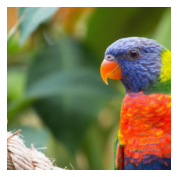

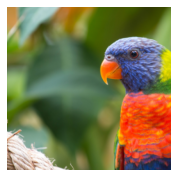

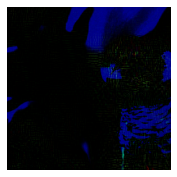

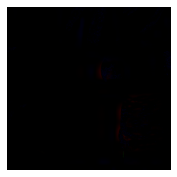

In [9]:
# Generate images for Figure 1

x = Image.open('Image_for_Fig_1.png')
x = transforms.ToTensor()(x)
x = transforms.Resize(size=(256,256))(x)
x = x.unsqueeze(0).to(device)

model = models.mobilenet_v3_small(pretrained=True).eval().to(device)
output = model(x)
y = nn.Softmax(dim=1)(output).max(1)[1]

CW = CWL2(model, search_steps=1)
LFCW = DWT_CWL2(model, J=4, search_steps=1)

x_CW = CW(x, y, 1e-6)
x_LFCW = LFCW(x, y, 1e-6)

plt.figure(figsize=(3, 3))
plt.imshow(x_CW.squeeze().detach().cpu().permute(1,2,0))
plt.axis('off')
plt.savefig('CW_attack.png')

plt.figure(figsize=(3, 3))
plt.imshow(x_LFCW.squeeze().detach().cpu().permute(1,2,0))
plt.axis('off')
plt.savefig('LF_CW_attack.png')

plt.figure(figsize=(3, 3))
plt.imshow(20 * (x_CW - x).squeeze().detach().cpu().permute(1,2,0))
plt.axis('off')
plt.savefig('CW_perturbations.png')

plt.figure(figsize=(3, 3))
plt.imshow(20 * (x_LFCW - x).squeeze().detach().cpu().permute(1,2,0))
plt.axis('off')
plt.savefig('LFCW_perturbation.png')


In [10]:
# Generate data for Figure 5, 7, or 8
# Figure 9 uses the same data as Figure 8

Figure = 5
num_batches = 1

JPEG = jpeg_compression(quality=25)
GaussBlur = torchvision.transforms.GaussianBlur(kernel_size=3)

if Figure == 5:
    model = CIFAR10CNN()
    modelname = 'CIFARCNN'
    dataloader = CIFAR_testloader
    defenses = [None, JPEG, wavelet_denoise, soft_threshold, PCA_denoise]
    defense_names = ['ND', 'JPEG', 'WD', 'ST', 'PCA']
elif Figure == 7:
    model = MNISTCNN()
    modelname = 'MNISTCNN'
    dataloader = MNIST_testloader
    defenses = [None, PCA_denoise, GaussBlur]
    defense_names = ['ND', 'PCA', 'GB', 'DVAE']
elif Figure == 8:
    model = resnet20()
    modelname = 'CIFAR10ResNet20'
    dataloader = CIFAR_testloader
    defenses = [None, JPEG, wavelet_denoise,  PCA_denoise, GaussBlur]
    defense_names = ['ND', 'JPEG', 'WD', 'PCA', 'GB']

if use_gpu:
    state_dict = torch.load('Models/' + modelname + '.pt')
    model.load_state_dict(state_dict)
else:
    state_dict = torch.load('Models/' + modelname + '.pt',
                            map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
model.to(device)
model.eval()

# :perts1:, :perts2:, and :perts3: are lists of pre-computed perturbations
# we use a custom class inheriting from :list: to have _.name, _.model, and
# _.device like in the attack classes
perts = generate_perturbations(CWL2(model, search_steps=1), dataloader, num_batches)
perts1 = customList('CWL2', model)
perts1 += perts
perts = generate_perturbations(DWT_CWL2(model, J=1, search_steps=1), dataloader, num_batches)
perts2 = customList('LF_CWL2_J1', model)
perts2 += perts
perts = generate_perturbations(DWT_CWL2(model, J=2, search_steps=1), dataloader, num_batches)
perts3 = customList('LF_CWL2_J2', model)
perts3 += perts
del perts

# when :accuracy_testing: is given in instance of :list: as :attack: the
# elements of the list will be treated as pre-computed perturbations
attacks = [FGM(model), Auto_PGD(model), perts1,
           DWT_FGSM(model, J=1, name='LF_FGSM_J1'),
           DWT_Auto_PGD(model, J=1, name='LF_Auto_PGD_J1'), perts2,
           DWT_FGSM(model, J=2, name='LF_FGSM_J2'),
           DWT_Auto_PGD(model, J=2, name='LF_Auto_PGD_J2'), perts3]

max_eps = [0.03, 0.045, 7.5, 0.06, 0.075, 7.2, 0.12, 0.14, 3.45]

# the data for each attack will be saved to f'{modelname}{attack.name}.txt' at
# :dir_str: + 'Saves/Data/Fig_7_9
if not os.path.exists('Saves/Data/Fig_7_9'):
    os.mkdir('Saves/Data/Fig_7_9')

for i, attack in enumerate(attacks):
    print(f'\nTesting attack {attack.name}')
    results = [[] for d in defenses]
    l2s, linfs, std_l2, std_linf = [], [], [], []

    epss = torch.linspace(0.0, max_eps[i], 20).tolist()
    for eps in epss:
        acc, l2, stdl2, linf, stdlinf = accuracy_testing(attack, eps,
                                                         dataloader, defenses,
                                                         num_batches)
        for i in range(len(defenses)):
            results[i].append(acc[i])
        l2s.append(l2)
        linfs.append(linf)
        std_l2.append(stdl2)
        std_linf.append(stdlinf)

    col_names = ['eps', 'l2s', 'linfs', 'stdl2', 'stdlinf'] + defense_names
    content = ', '.join(col_names) + '\n'
    for j in range(len(epss)):
        string = f'{epss[j]}, {l2s[j]}, {linfs[j]}, {std_l2[j]}, {std_linf[j]}'
        for r in results:
            string += f', {r[j]}'
        content += string + '\n'

    with open(f'Saves/Data/Fig_7_9/{modelname}{attack.name}.txt', 'w') as f:
        f.write(content)

    print('')

Generating perturbations for CWL2
Batch: 1 / 1
Generating perturbations for DWT_CWL2
Batch: 1 / 1
Generating perturbations for DWT_CWL2
Batch: 1 / 1

Testing attack FGM
Batch 1/1, eps: 0.0299999993294477465

Testing attack Auto_PGD
Batch 1/1, eps: 0.045000001788139345

Testing attack CWL2
Batch 1/1, eps: 7.5052632331848145

Testing attack LF_FGSM_J1
Batch 1/1, eps: 0.059999998658895494

Testing attack LF_Auto_PGD_J1
Batch 1/1, eps: 0.075000002980232244

Testing attack LF_CWL2_J1
Batch 1/1, eps: 7.19999980926513753

Testing attack LF_FGSM_J2
Batch 1/1, eps: 0.119999997317790994

Testing attack LF_Auto_PGD_J2
Batch 1/1, eps: 0.14000000059604645

Testing attack LF_CWL2_J2
Batch 1/1, eps: 3.45000004768371633


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


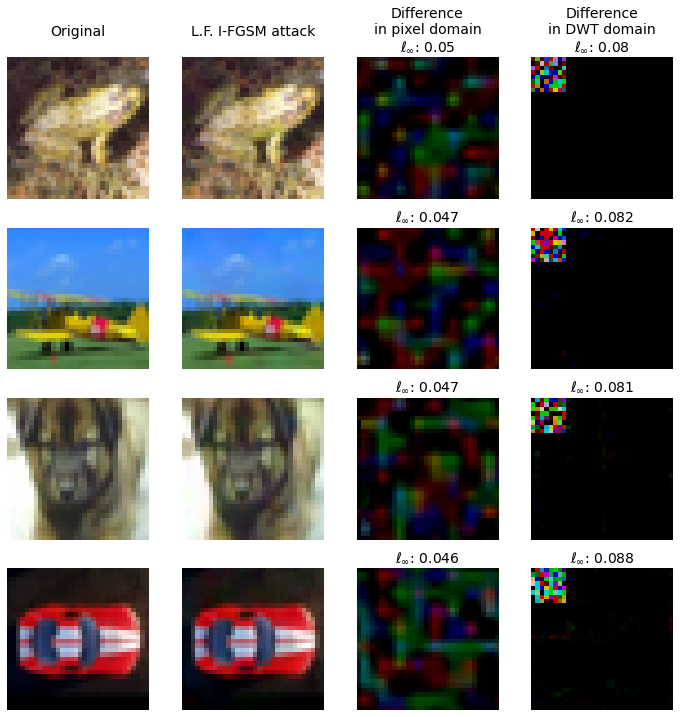

In [13]:
# Generate Figure 4

model = CIFAR10CNN()
modelfile = 'CIFARCNN.pt'
dataloader = CIFAR_testloader

if use_gpu:
    state_dict = torch.load('Models/' + modelfile)
    model.load_state_dict(state_dict)
else:
    state_dict = torch.load('Models/' + modelfile,
                            map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
model.to(device)
model.eval()

x, l = next(iter(dataloader))
x = x.to(device)
J = 2
idxs = [19, 44, 33, 81]

IFGSM = DWT_PGD(model, iters=40, rand_restarts=0, J=2)

x_adv = IFGSM(x, l, eps=0.08)
DWT = DWTForward(J=J, wave='db3', mode='periodization').to(device)
iDWT = DWTInverse(wave='db3', mode='periodization').to(device)

def stack_wavelet_coefficient_tensors(l, h, J, img_shape):
    '''
    Stacks wavelet coefficient tensors obtained by l, h = DWT(image) to the
    original image shape. Assumes mode for DWT is 'periodization'.

    :l:         Low freq. coefficient tensor
    :h:         List of high freq. coefficient tensors
    :J:         DWT scale
    :img_shape: Shape of the original image as list of ints.
    '''
    x = torch.zeros(img_shape, device=device)
    sl = l.shape
    x[:, :, :sl[-2], :sl[-1]] = l

    dx = sl[-1]
    dy = sl[-2]

    for i in range(J):
        i = J - 1 - i
        sh = h[i].shape
        x[:, :, dx:dx+sh[-2], :sh[-1]] = h[i][:, :, 0, :, :]
        x[:, :, dx:dx+sh[-2], dy:dy+sh[-1]] = h[i][:, :, 2, :, :]
        x[:, :, :sh[-2], dy:dy+sh[-1]] = h[i][:, :, 1, :, :]

        dx += sh[-1]
        dy += sh[-2]

    return x

diff_pix = x_adv - x
x_l, x_h = DWT(x)
x_adv_l, x_adv_h = DWT(x_adv)

diff_l = x_adv_l - x_l
diff_h = [x_adv_h[i] - x_h[i] for i in range(len(x_h))]
diff_dwt = stack_wavelet_coefficient_tensors(diff_l, diff_h, J, x.shape)

fig = plt.figure(figsize=(12,12))

colticks = np.linspace(0, 0.2, 5, endpoint=True)

for i in range(4):
    plt.subplot(4,4,4*i+1)
    plt.imshow(x[idxs[i]].squeeze().cpu().permute(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title('Original\n ')

    plt.subplot(4,4,4*i+2)
    plt.imshow(x_adv[idxs[i]].squeeze().cpu().permute(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title('L.F. I-FGSM attack\n ')

    plt.subplot(4,4,4*i+3)
    plt.imshow(diff_pix[idxs[i]].squeeze().cpu().permute(1,2,0) * 10)
    plt.axis('off')
    if i == 0:
        plt.title('Difference\nin pixel domain\n$\ell_\infty$: ' +
                  f'{torch.norm(diff_pix[idxs[i]], p=float("inf")).item():.2f}')
    else:
        plt.title('$\ell_\infty$: ' +
                  f'{torch.norm(diff_pix[idxs[i]], p=float("inf")).item():.3f}')

    plt.subplot(4,4,4*i+4)
    plt.imshow(diff_dwt[idxs[i]].squeeze().cpu().permute(1,2,0) * 10)
    plt.axis('off')
    if i == 0:
        plt.title('Difference\nin DWT domain\n$\ell_\infty$: ' +
                  f'{torch.norm(diff_dwt[idxs[i]], p=float("inf")).item():.2f}')
    else:
        plt.title('$\ell_\infty$: ' +
                  f'{torch.norm(diff_dwt[idxs[i]], p=float("inf")).item():.3f}')



In [15]:
# Generate data for Table 1
num_batches = None

model = CIFAR10CNN()
modelfile = 'CIFARCNN.pt'
dataloader = CIFAR_testloader

if use_gpu:
    state_dict = torch.load('Models/' + modelfile)
    model.load_state_dict(state_dict)
else:
    state_dict = torch.load('Models/' + modelfile,
                            map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
model.to(device)
model.eval()

# DWT FGSM that perturbs all DWT coefficients
class All_Freq_FGSM(DWT_FGSM):

    def FGSM_no_iDWT(self, x, y, eps=0.0):
        x = x.to(self.device)
        y = y.to(self.device)
        
        x_l, x_h = self.DWT(x)
        x_l.requires_grad = True
        x_h = [h.requires_grad_(True) for h in x_h]
        
        outs = self.model(self.iDWT((x_l, x_h)))
        self.model.zero_grad()
        loss = self.loss_fn(outs, y).to(self.device)
        loss.backward()
        
        tmp = (1 - 2 * self.targeted)
        x_l = (x_l + tmp * eps * x_l.grad.sign()).detach()
        x_h = [(h + tmp * eps * h.grad.sign()).detach() for h in x_h]
        
        return x_l, x_h

pixel_FGSM = FGM(model)
lf_FGSM = DWT_FGSM(model)
allf_FGSM = All_Freq_FGSM(model)
def identity(x, y, eps):
    return x

print('Testing pixel FGSM:')
tmp = accuracy_testing(pixel_FGSM, 0.03, dataloader,
                       num_batches=num_batches, defenses=[None])
acc_pixel = tmp[0][0]
print('\nTesting low-freq. FGSM:')
tmp = accuracy_testing(lf_FGSM, 0.06, dataloader,
                       num_batches=num_batches, defenses=[None])
acc_lf = tmp[0][0]
print('\nTesting DWT FGSM:')
tmp = accuracy_testing(allf_FGSM, 0.03, dataloader,
                       num_batches=num_batches, defenses=[None])
acc_allf = tmp[0][0]
print('\nTesting natural accuracy:')
tmp = accuracy_testing(pixel_FGSM, 0.0, dataloader,
                       num_batches=num_batches, defenses=[None])
acc_nat = tmp[0][0]

print('\n\nAccuracies:')
print(f'pixel: {acc_pixel}, l.f.: {acc_lf}, ',
      f'DWT: {acc_allf}, Nat. Acc.: {acc_nat}')

Testing pixel FGSM:
Batch 100/100, eps: 0.03
Testing low-freq. FGSM:
Batch 100/100, eps: 0.06
Testing DWT FGSM:
Batch 100/100, eps: 0.03
Testing natural accuracy:
Batch 100/100, eps: 0.0

Accuracies:
pixel: 0.28828057646751404, l.f.: 0.37883415818214417,  DWT: 0.2895026206970215, Nat. Acc.: 1.0


In [17]:
# Generate data for Table 1
num_batches = None

model = CIFAR10CNN()
modelfile = 'CIFARCNN.pt'
dataloader = CIFAR_testloader

if use_gpu:
    state_dict = torch.load('Models/' + modelfile)
    model.load_state_dict(state_dict)
else:
    state_dict = torch.load('Models/' + modelfile,
                            map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
model.to(device)
model.eval()

epss = [0.01, 0.02, 0.01, 0.02, 1e-6, 1e-6]
JPEG = jpeg_compression(quality=25)

# give FGSM and PGD to a binary search class
# CWL2 already has binary search
attacks = [FGM(model), DWT_FGSM(model, J=2), 
           PGD(model, iters=40), DWT_PGD(model, J=2, iters=40)]
attacks = [binary_search(a, 100, epss[i]) for i, a in enumerate(attacks)]
attacks.append(CWL2(model))
attacks.append(DWT_CWL2(model, J=2))

for i, attack in enumerate(attacks):
    defenses = [JPEG, wavelet_denoise, soft_threshold, PCA_denoise]

    result = accuracy_testing(attack, epss[i], dataloader, 
                              num_batches=num_batches, defenses=defenses)
    acc, l2 = result[0], result[1]

    print('\n' + attack.name)
    col_names = ['l2s', 'nd', 'jpeg', 'wd', 'st', 'pca']
    print(' '.join(col_names))
    string = str(l2)
    for a in acc:
        string += f' & {a}'
    print(string)

Batch 100/100, eps: 0.01
FGM
l2s nd jpeg wd st pca
0.31433576345443726 & 0.38567763566970825 & 0.32555297017097473 & 0.341317355632782 & 0.22461199760437012
Batch 100/100, eps: 0.02
DWT_FGSM
l2s nd jpeg wd st pca
0.20329897105693817 & 0.3150433897972107 & 0.2546743154525757 & 0.23426616191864014 & 0.21373578906059265
Batch 100/100, eps: 0.01
PGD
l2s nd jpeg wd st pca
0.10079856961965561 & 0.462910920381546 & 0.41439568996429443 & 0.3964316248893738 & 0.21092508733272552
Batch 100/100, eps: 0.02
DWT_PGD
l2s nd jpeg wd st pca
0.10897989571094513 & 0.24416473507881165 & 0.1261151134967804 & 0.12183795869350433 & 0.1000855416059494
Batch 100/100, eps: 1e-06
CWL2
l2s nd jpeg wd st pca
0.008333371952176094 & 0.7899303436279297 & 0.8913601636886597 & 0.6904557943344116 & 0.8999144434928894
Batch 100/100, eps: 1e-06
DWT_CWL2
l2s nd jpeg wd st pca
0.0007315970142371953 & 0.8144934773445129 & 0.9322986602783203 & 0.7122082114219666 & 0.9508737921714783


Device: cuda
Files already downloaded and verified
Files already downloaded and verified

Generating data for Table 1:
Testing pixel FGSM:
Batch 2/2, eps: 0.03
Testing low-freq. FGSM:
Batch 2/2, eps: 0.06
Testing DWT FGSM:
Batch 2/2, eps: 0.03
Testing natural accuracy:
Batch 2/2, eps: 0.0

Generating data for Table 2:
Testing attack FGM
Batch 2/2, eps: 0.01
Testing attack DWT_FGSM
Batch 2/2, eps: 0.02
Testing attack PGD
Batch 2/2, eps: 0.01
Testing attack DWT_PGD
Batch 2/2, eps: 0.02
Testing attack CWL2
Batch 2/2, eps: 1e-06
Testing attack DWT_CWL2
Batch 2/2, eps: 1e-06

Generating images for Figure 1:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generating Figure 4:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Generating data for Figure 5:
Generating perturbations for CWL2
Batch: 2 / 2
Generating perturbations for DWT_CWL2


Traceback (most recent call last):
  File "/home/ssadiku/anaconda3/envs/pwsmooth_adversarialattacks/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/ssadiku/anaconda3/envs/pwsmooth_adversarialattacks/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ssadiku/anaconda3/envs/pwsmooth_adversarialattacks/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/ssadiku/anaconda3/envs/pwsmooth_adversarialattacks/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Batch: 2 / 2

Testing attack FGM
Batch 2/2, eps: 0.0299999993294477465
Testing attack PGD
Batch 2/2, eps: 0.059999998658895494
Testing attack CWL2
Batch 2/2, eps: 7.5052632331848145
Testing attack LF_FGSM_J2
Batch 2/2, eps: 0.119999997317790994
Testing attack LF_IFGSM_J2
Batch 2/2, eps: 0.119999997317790994
Testing attack LF_CWL2_J2
Batch 2/2, eps: 3.45000004768371633

Generating data for Figure 8:
Generating perturbations for CWL2
Batch: 2 / 2
Generating perturbations for DWT_CWL2
Batch: 2 / 2

Testing attack FGM
Batch 2/2, eps: 0.0299999993294477465
Testing attack Auto_PGD
Batch 2/2, eps: 0.045000001788139345
Testing attack CWL2
Batch 2/2, eps: 7.5052632331848145
Testing attack LF_FGSM_J2
Batch 2/2, eps: 0.119999997317790994
Testing attack LF_Auto_PGD_J2
Batch 2/2, eps: 0.14000000059604645
Testing attack LF_CWL2_J2
Batch 2/2, eps: 3.45000004768371633

Generating data for Figure 7 and 9:
Generating perturbations for CWL2
Batch: 2 / 2
Generating perturbations for DWT_CWL2
Batch: 2 / 2


Traceback (most recent call last):


Batch 2/2, eps: 3.4500000476837163


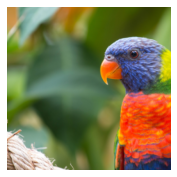

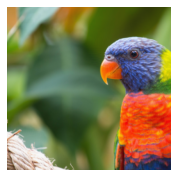

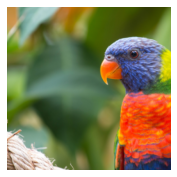

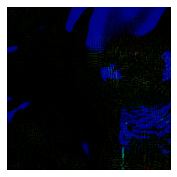

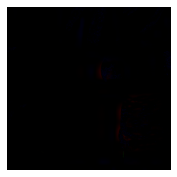

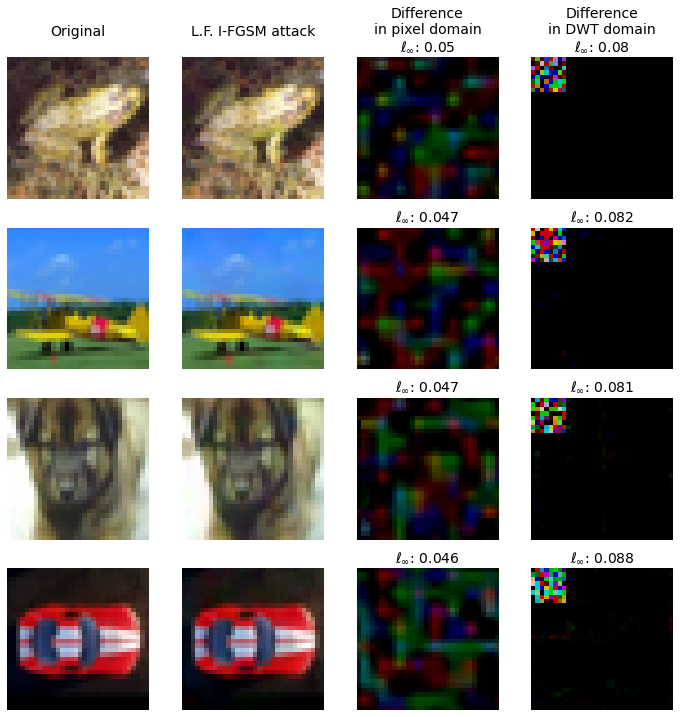

In [26]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
print(f'Device: {device}')


if not os.path.exists('Saves/Data/'):
    os.makedirs('Saves/Data/')
if not os.path.exists('Saves/Models/'):
    os.makedirs('Saves/Models/')
if not os.path.exists('Saves/Data/Fig_1'):
    os.mkdir('Saves/Data/Fig_1')
if not os.path.exists('Saves/Data/Fig_5'):
    os.mkdir('Saves/Data/Fig_5')
if not os.path.exists('Saves/Data/Fig_7_9'):
    os.mkdir('Saves/Data/Fig_7_9')
if not os.path.exists('Saves/Data/Fig_8'):
    os.mkdir('Saves/Data/Fig_8')

# set font sizes ofr pyplot
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

BATCH_SIZE = 100
SHUFFLE = False
num_batches = 2

CIFAR_trainloader = torch.utils.data.DataLoader(
    datasets.CIFAR10("Saves/Data/", download=True, train=True,
                     transform=transforms.Compose([
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor()])),
                     batch_size=BATCH_SIZE, shuffle=SHUFFLE,
                     num_workers=2, pin_memory=True)

CIFAR_testloader = torch.utils.data.DataLoader(
    datasets.CIFAR10("Saves/Data/", download=True, train=False,
                     transform=transforms.Compose([transforms.ToTensor()])),
                     batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=2,
                     pin_memory=True)

MNIST_trainloader = torch.utils.data.DataLoader(
    datasets.MNIST("Saves/Data/", download=True, train=True,
                   transform=transforms.Compose([transforms.ToTensor()])),
                   batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=2,
                   pin_memory=True)

MNIST_testloader = torch.utils.data.DataLoader(
    datasets.MNIST("Saves/Data/", download=True, train=False,
                   transform=transforms.Compose([transforms.ToTensor()])),
                   batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=2,
                   pin_memory=True)


def generateTable1():
    pixel_FGSM = FGM(model)
    lf_FGSM = DWT_FGSM(model)
    allf_FGSM = All_Freq_FGSM(model)
    def identity(x, y, eps):
        return x

    print('Testing pixel FGSM:')
    tmp = accuracy_testing(pixel_FGSM, 0.03, dataloader,
                        num_batches=num_batches, defenses=[None])
    acc_pixel = tmp[0][0]
    print('\nTesting low-freq. FGSM:')
    tmp = accuracy_testing(lf_FGSM, 0.06, dataloader,
                        num_batches=num_batches, defenses=[None])
    acc_lf = tmp[0][0]
    print('\nTesting DWT FGSM:')
    tmp = accuracy_testing(allf_FGSM, 0.03, dataloader,
                        num_batches=num_batches, defenses=[None])
    acc_allf = tmp[0][0]
    print('\nTesting natural accuracy:')
    tmp = accuracy_testing(pixel_FGSM, 0.0, dataloader,
                        num_batches=num_batches, defenses=[None])
    acc_nat = tmp[0][0]

    content = f'pixel: {acc_pixel}, l.f.: {acc_lf}, '
    content += f'DWT: {acc_allf}, Nat. Acc.: {acc_nat}'

    with open('Saves/Data/Table_1.txt', 'w') as f:
        f.write(content)

    print('\n')


def generateTable2():
    content = ''
    defenses = [JPEG, wavelet_denoise, soft_threshold, PCA_denoise]
    col_names = ['l2s', 'nd', 'jpeg', 'wd', 'st', 'pca']
    col_names = ', '.join(col_names)

    epss = [0.01, 0.02, 0.01, 0.02, 1e-6, 1e-6]
    # give FGSM and PGD to a binary search class
    # CWL2 already has binary search
    attacks = [FGM(model), DWT_FGSM(model, J=2), 
            PGD(model, iters=40), DWT_PGD(model, J=2, iters=40)]
    attacks = [binary_search(a, 100, epss[i]) for i, a in enumerate(attacks)]
    attacks.append(CWL2(model))
    attacks.append(DWT_CWL2(model, J=2, search_steps=1))

    for i, attack in enumerate(attacks):
        print(f'Testing attack {attack.name}')
        result = accuracy_testing(attack, epss[i], dataloader,
                                  num_batches=num_batches, defenses=defenses)
        print('')
        acc, l2 = result[0], result[1]

        content += attack.name + '\n'
        content += col_names + '\n'
        string = str(l2)
        for a in acc:
            string += f' & {a}'
        content += string + '\n'
    
    print('')
    with open('Saves/Data/Table_2.txt', 'w') as f:
        f.write(content)


def generateFig1():
    x = Image.open('Image_for_Fig_1.png')
    x = transforms.ToTensor()(x)
    x = transforms.Resize(size=(256,256))(x)
    x = x.unsqueeze(0).to(device)

    model = models.mobilenet_v3_small(pretrained=True).eval().to(device)
    output = model(x)
    y = nn.Softmax(dim=1)(output).max(1)[1]

    CW = CWL2(model, search_steps=1)
    LFCW = DWT_CWL2(model, J=4, search_steps=1)

    x_CW = CW(x, y, 1e-6)
    x_LFCW = LFCW(x, y, 1e-6)

    plt.figure(figsize=(3, 3))
    plt.imshow(x.squeeze().detach().cpu().permute(1,2,0))
    plt.axis('off')
    plt.savefig('Saves/Data/Fig_1/Original.png')

    plt.figure(figsize=(3, 3))
    plt.imshow(x_CW.squeeze().detach().cpu().permute(1,2,0))
    plt.axis('off')
    plt.savefig('Saves/Data/Fig_1/CW_attack.png')

    plt.figure(figsize=(3, 3))
    plt.imshow(x_LFCW.squeeze().detach().cpu().permute(1,2,0))
    plt.axis('off')
    plt.savefig('Saves/Data/Fig_1/LF_CW_attack.png')

    plt.figure(figsize=(3, 3))
    plt.imshow(20 * (x_CW - x).squeeze().detach().cpu().permute(1,2,0))
    plt.axis('off')
    plt.savefig('Saves/Data/Fig_1/CW_perturbation.png')

    plt.figure(figsize=(3, 3))
    plt.imshow(20 * (x_LFCW - x).squeeze().detach().cpu().permute(1,2,0))
    plt.axis('off')
    plt.savefig('Saves/Data/Fig_1/LFCW_perturbation.png')


def generateFig4():
    x, l = next(iter(dataloader))
    x = x.to(device)
    idxs = [19, 44, 33, 81]
    J = 2

    IFGSM = DWT_PGD(model, iters=40, rand_restarts=0, J=2)

    x_adv = IFGSM(x, l, eps=0.08)
    DWT = DWTForward(J=J, wave='db3', mode='periodization').to(device)
    iDWT = DWTInverse(wave='db3', mode='periodization').to(device)

    diff_pix = x_adv - x
    x_l, x_h = DWT(x)
    x_adv_l, x_adv_h = DWT(x_adv)

    diff_l = x_adv_l - x_l
    diff_h = [x_adv_h[i] - x_h[i] for i in range(len(x_h))]
    diff_dwt = stack_wavelet_coefficient_tensors(diff_l, diff_h, J, x.shape)

    plt.figure(figsize=(12,12))
    colticks = np.linspace(0, 0.2, 5, endpoint=True)
    for i in range(4):
        plt.subplot(4,4,4*i+1)
        plt.imshow(x[idxs[i]].squeeze().cpu().permute(1,2,0))
        plt.axis('off')
        if i == 0:
            plt.title('Original\n ')

        plt.subplot(4,4,4*i+2)
        plt.imshow(x_adv[idxs[i]].squeeze().cpu().permute(1,2,0))
        plt.axis('off')
        if i == 0:
            plt.title('L.F. I-FGSM attack\n ')

        plt.subplot(4,4,4*i+3)
        plt.imshow(diff_pix[idxs[i]].squeeze().cpu().permute(1,2,0) * 10)
        plt.axis('off')
        if i == 0:
            plt.title('Difference\nin pixel domain\n$\ell_\infty$: ' +
                      f'{torch.norm(diff_pix[idxs[i]], p=float("inf")).item():.2f}')
        else:
            plt.title('$\ell_\infty$: ' +
                      f'{torch.norm(diff_pix[idxs[i]],p=float("inf")).item():.3f}')

        plt.subplot(4,4,4*i+4)
        plt.imshow(diff_dwt[idxs[i]].squeeze().cpu().permute(1,2,0) * 10)
        plt.axis('off')
        if i == 0:
            plt.title('Difference\nin DWT domain\n$\ell_\infty$: ' +
                      f'{torch.norm(diff_dwt[idxs[i]], p=float("inf")).item():.2f}')
        else:
            plt.title('$\ell_\infty$: ' +
                      f'{torch.norm(diff_dwt[idxs[i]], p=float("inf")).item():.3f}')
    
    plt.savefig('Saves/Data/Figure_4.png')


def generateFigs5789(model, attacks: list, max_eps: list, defenses: list,
                     defense_names: list, dir: str):
    for i, attack in enumerate(attacks):
        print(f'\nTesting attack {attack.name}')
        results = [[] for d in defenses]
        l2s, linfs, std_l2, std_linf = [], [], [], []

        epss = torch.linspace(0.0, max_eps[i], 20).tolist()
        for eps in epss:
            acc, l2, stdl2, linf, stdlinf = accuracy_testing(attack, eps,
                                                             dataloader,
                                                             defenses,
                                                             num_batches)
            for i in range(len(defenses)):
                results[i].append(acc[i])
            l2s.append(l2)
            linfs.append(linf)
            std_l2.append(stdl2)
            std_linf.append(stdlinf)

        col_names = ['eps', 'l2s', 'linfs', 'stdl2', 'stdlinf'] + defense_names
        content = ', '.join(col_names) + '\n'
        for j in range(len(epss)):
            string = f'{epss[j]}, {l2s[j]}, {linfs[j]}, {std_l2[j]}, {std_linf[j]}'
            for r in results:
                string += f', {r[j]}'
            content += string + '\n'

        with open(dir + f'{attack.name}.txt', 'w') as f:
            f.write(content)

    print('')


if __name__ == "__main__":
    print('')
    JPEG = jpeg_compression(quality=25)
    GaussBlur = torchvision.transforms.GaussianBlur(kernel_size=3)

    dataloader = CIFAR_testloader
    model = CIFAR10CNN()
    if use_gpu:
        state_dict = torch.load('Models/CIFARCNN.pt')
        model.load_state_dict(state_dict)
    else:
        state_dict = torch.load('Models/CIFARCNN.pt',
                                map_location=torch.device('cpu'))
        model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    
    print('Generating data for Table 1:')
    generateTable1()
    print('Generating data for Table 2:')
    generateTable2()
    print('Generating images for Figure 1:')
    generateFig1()
    print('Generating Figure 4:')
    generateFig4()
    print('')

    defenses = [None, JPEG, wavelet_denoise, soft_threshold, PCA_denoise]
    defense_names = ['ND', 'JPEG', 'WD', 'ST', 'PCA']

    print('Generating data for Figure 5:')
    # :perts1: and :perts2: are lists of pre-computed perturbations
    # we use a custom class inheriting from :list: to have _.name, _.model, and
    # _.device like in the attack classes
    perts = generate_perturbations(CWL2(model), dataloader, num_batches)
    perts1 = customList('CWL2', model)
    perts1 += perts
    perts = generate_perturbations(DWT_CWL2(model, J=2), dataloader, num_batches)
    perts2 = customList('LF_CWL2_J2', model)
    perts2 += perts
    del perts

    attacks = [FGM(model), PGD(model, iters=40), perts1,
               DWT_FGSM(model, J=2, name='LF_FGSM_J2'),
               DWT_PGD(model, iters=40, J=2, name='LF_IFGSM_J2'), perts2]

    max_eps = [0.03, 0.06, 7.5, 0.12, 0.12, 3.45]
    generateFigs5789(model, attacks, max_eps, defenses, defense_names, 'Saves/Data/Fig_5/')
    print('')

    model = MNISTCNN()
    if use_gpu:
        state_dict = torch.load('Models/MNISTCNN.pt')
        model.load_state_dict(state_dict)
    else:
        state_dict = torch.load('Models/MNISTCNN.pt',
                                map_location=torch.device('cpu'))
        model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    defenseVAE = VAE1()
    if use_gpu:
        state_dict = torch.load('Models/DVAE.pt')
        defenseVAE.load_state_dict(state_dict)
    else:
        state_dict = torch.load('Models/DVAE.pt',
                                map_location=torch.device('cpu'))
        defenseVAE.load_state_dict(state_dict)
    defenseVAE.to(device)
    defenseVAE.eval()

    def DVAE(x):
        return defenseVAE(x)[0]

    dataloader = MNIST_testloader
    defenses = [None, PCA_denoise, GaussBlur, DVAE]
    defense_names = ['ND', 'PCA', 'GB', 'DVAE']

    print('Generating data for Figure 8:')
    perts = generate_perturbations(CWL2(model), dataloader, num_batches)
    perts1 = customList('CWL2', model)
    perts1 += perts
    perts = generate_perturbations(DWT_CWL2(model, J=2), dataloader, num_batches)
    perts2 = customList('LF_CWL2_J2', model)
    perts2 += perts
    del perts

    attacks = [FGM(model), Auto_PGD(model), perts1,
               DWT_FGSM(model, J=2, name='LF_FGSM_J2'),
               DWT_PGD(model, J=2, name='LF_Auto_PGD_J2'), perts2]

    max_eps = [0.03, 0.045, 7.5, 0.12, 0.14, 3.45]
    generateFigs5789(model, attacks, max_eps, defenses, defense_names, 'Saves/Data/Fig_8/')
    print('')

    model = resnet20()
    if use_gpu:
        state_dict = torch.load('Models/CIFAR10ResNet20.pt')
        model.load_state_dict(state_dict)
    else:
        state_dict = torch.load('Models/CIFAR10ResNet20.pt',
                                map_location=torch.device('cpu'))
        model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    dataloader = CIFAR_testloader
    defenses = [None, JPEG, wavelet_denoise,  PCA_denoise, GaussBlur]
    defense_names = ['ND', 'JPEG', 'WD', 'PCA', 'GB']

    print('Generating data for Figure 7 and 9:')
    perts = generate_perturbations(CWL2(model), dataloader, num_batches)
    perts1 = customList('CWL2', model)
    perts1 += perts
    perts = generate_perturbations(DWT_CWL2(model, J=1), dataloader, num_batches)
    perts2 = customList('LF_CWL2_J1', model)
    perts2 += perts
    perts = generate_perturbations(DWT_CWL2(model, J=2), dataloader, num_batches)
    perts3 = customList('LF_CWL2_J2', model)
    perts3 += perts
    del perts

    # when :accuracy_testing: is given in instance of :list: as :attack: the
    # elements of the list will be treated as pre-computed perturbations
    attacks = [FGM(model), Auto_PGD(model), perts1,
               DWT_FGSM(model, J=1, name='LF_FGSM_J1'),
               DWT_Auto_PGD(model, J=1, name='LF_Auto_PGD_J1'), perts2,
               DWT_FGSM(model, J=2, name='LF_FGSM_J2'),
               DWT_Auto_PGD(model, J=2, name='LF_Auto_PGD_J2'), perts3]

    max_eps = [0.03, 0.045, 7.5, 0.06, 0.075, 7.2, 0.12, 0.14, 3.45]
    generateFigs5789(model, attacks, max_eps, defenses, defense_names, 'Saves/Data/Fig_7_9/')